In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets, metrics
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV
from gensvm import GenSVM, GenSVMGridSearchCV
from ipywidgets import interact_manual
import ipywidgets as widgets
import pickle

In [2]:
def make_meshgrid(x, y, h=0.005):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, trainX, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()], trainX=trainX)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern'],
    "font.size": 14
})

In [4]:
def plot_iris(kernel, gamma, kappa, p, degree):
    iris = datasets.load_iris()
    X = iris.data[:, :2]
    y = iris.target

    model = GenSVM(kernel=kernel, gamma=gamma, kappa=kappa, p=p, degree=degree).fit(X, y)

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(plt, model, xx, yy, X, cmap=plt.cm.coolwarm, alpha=0.8)
    scatter = plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel("sepal length (cm)")
    plt.ylabel("sepal width (cm)")
    plt.xticks(())
    plt.yticks(())
    _ = plt.legend(
        scatter.legend_elements()[0], iris.target_names, loc="lower right"
    )
    plt.savefig('interactive_plot.pdf')
    plt.show()

In [5]:
interact_manual(
    plot_iris, 
    kernel=['linear', 'rbf', 'poly'], 
    gamma=widgets.FloatSlider(min=.1, max=1, step=.1, value=.3),
    p=widgets.FloatSlider(min=1, max=2, step=.1, value=1),
    kappa=widgets.FloatSlider(min=-0.9, max=10, step=.1, value=2),
    degree=widgets.IntSlider(min=1, max=5, step=1, value=2)
)

interactive(children=(Dropdown(description='kernel', options=('linear', 'rbf', 'poly'), value='linear'), Float…

<function __main__.plot_iris(kernel, gamma, kappa, p, degree)>

In [6]:
class GenSVMClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, p=1.0, lmd=1e-5, kappa=0.0, weights='unit', kernel='linear', gamma='auto', coef=1.0, degree=2.0, kernel_eigen_cutoff=1e-8, verbose=0, random_state=None, max_iter=1e8):
        self.p = p
        self.lmd = lmd
        self.kappa = kappa
        self.weights = weights
        self.kernel = kernel
        self.gamma = gamma
        self.coef = coef
        self.degree = degree
        self.kernel_eigen_cutoff = kernel_eigen_cutoff
        self.verbose = verbose
        self.random_state = random_state
        self.max_iter = max_iter

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.clf_ = GenSVM(**self.get_params())
        self.clf_.fit(X, y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return self.clf_.predict(X, trainX=self.X_)

In [7]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

param_grid = [
    {
        'p': [1, 1.5, 2], 
        'kappa': [1, 2, 5, 10], 
        'gamma': [1, 0.1, 0.01, 0.001], 
        'kernel': ['rbf']
    },
    {
        'p': [1, 1.5, 2], 
        'kappa': [1, 2, 5, 10], 
        'kernel': ['linear']
    },
    {
        'p': [1, 1.5, 2], 
        'kappa': [1, 2, 5, 10], 
        'coef': [0.1, 1, 10, 100], 
        'degree': [2, 3], 
        'kernel': ['poly']
    }
] 

with open('pickle/gridsearch2.pkl', 'rb') as f:
    grid = pickle.load(f)

# grid = GridSearchCV(GenSVMClassifier(), param_grid, scoring='balanced_accuracy', verbose=3)
# grid.fit(X, y)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Best parameters: {'gamma': 0.01, 'kappa': 1, 'kernel': 'rbf', 'p': 1}
Best score: 0.9866666666666667


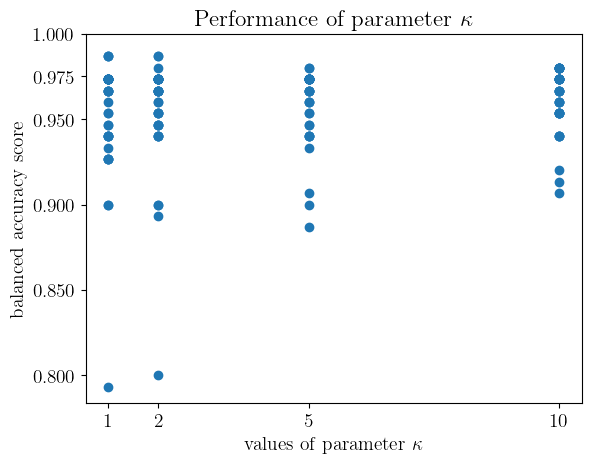

In [8]:
plt.scatter(grid.cv_results_['param_kappa'], grid.cv_results_['mean_test_score'])
plt.xticks([1, 2, 5, 10])
plt.yticks([0.8, 0.85, 0.9, 0.95, 0.975, 1])
plt.xlabel('values of parameter $\kappa$')
plt.ylabel('balanced accuracy score')
plt.title('Performance of parameter $\kappa$')
plt.savefig('performance_kappa.pdf')
plt.show()

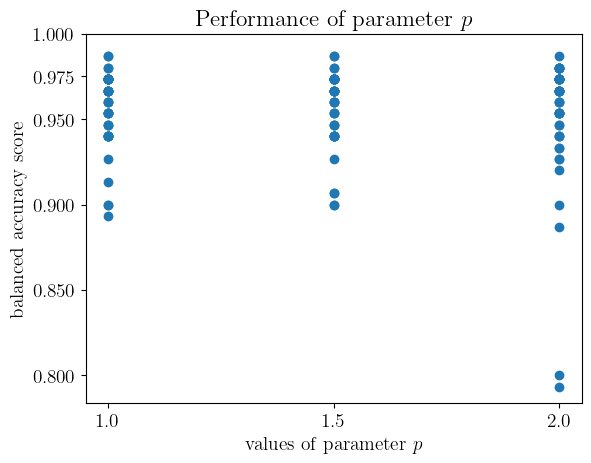

In [9]:
plt.scatter(grid.cv_results_['param_p'], grid.cv_results_['mean_test_score'])
#plt.xscale('log')
plt.xticks([1, 1.5, 2])
plt.yticks([0.8, 0.85, 0.9, 0.95, 0.975, 1])
plt.xlabel('values of parameter $p$')
plt.ylabel('balanced accuracy score')
plt.title('Performance of parameter $p$')
plt.savefig('performance_p.pdf')
plt.show()

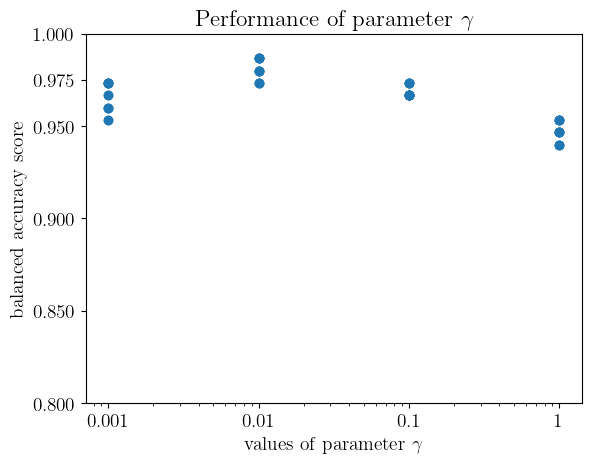

In [10]:
plt.scatter(grid.cv_results_['param_gamma'], grid.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xticks([1, 0.1, 0.01, 0.001], ['1', '0.1', '0.01', '0.001'])
plt.yticks([0.8, 0.85, 0.9, 0.95, 0.975, 1])
plt.xlabel('values of parameter $\gamma$')
plt.ylabel('balanced accuracy score')
plt.title('Performance of parameter $\gamma$')
plt.savefig('performance_gamma.pdf')
plt.show()

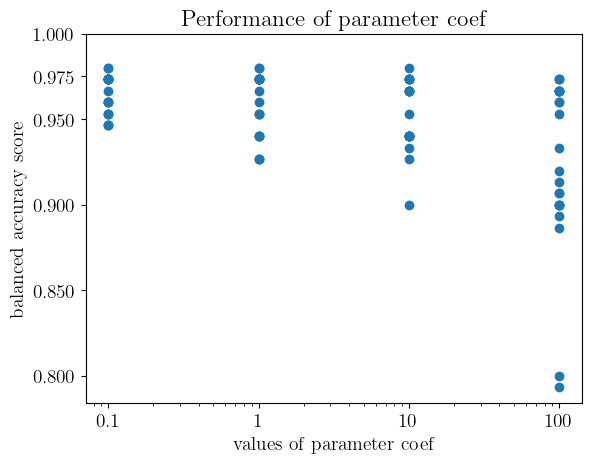

In [11]:
plt.scatter(grid.cv_results_['param_coef'], grid.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xticks([0.1, 1, 10, 100], ['0.1', '1', '10', '100'])
plt.yticks([0.8, 0.85, 0.9, 0.95, 0.975, 1])
plt.xlabel('values of parameter coef')
plt.ylabel('balanced accuracy score')
plt.title('Performance of parameter coef')
plt.savefig('performance_coef.pdf')
plt.show()